# cleanup data: drifters

To do:

- process drifters1: 
    - [X] highlight observed erros (jumps)
    - [ ] produce movies of trajectories
    - [ ] produce movies of relative evolution


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
campaign="taos0_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque


---

## drifters

`drifters_bin.csv` is a binary csv file and it was converted into an ascii csv file with:

```
cat drifters_bin.csv | tr -d '\0' > drifters.csv
```



In [3]:
def read_drifters(file):
    
    df = pd.read_csv(file, parse_dates=[1])
    df["DeviceDateTime"]
    
    df = (df
          .rename(columns=dict(DeviceName="id", DeviceDateTime="time", 
                               Latitude="latitude", Longitude="longitude"))
          .sort_values("id")
         )
    #df["id"] = df["id"].map(lambda v: v.replace("-",""))
    df = df.set_index("id")
        
    return df

In [28]:
drifter_file = os.path.join(cp.pathr, "drifters.csv")
df = read_drifters(drifter_file)
df.head()

,time,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude
id,,,,,,,,
0-4351896,2022-05-18 06:17:21,GOOD,0-4351896,0,0,3,49.413167,-0.389650
0-4351896,2022-05-18 15:37:21,GOOD,0-4351896,0,0,3,49.381120,-0.319612
0-4351896,2022-05-17 23:12:20,GOOD,0-4351896,0,0,3,49.368052,-0.244832
0-4351896,2022-05-17 14:22:23,GOOD,0-4351896,0,0,3,49.362044,-0.305364
0-4351896,2022-05-19 03:37:24,GOOD,0-4351896,0,0,3,49.380347,-0.279851


### compute and show typical time intervals

This is to decide on a reasonable target timeline.
A 2 minutes sampling rate seems reasonable.

Percentage of time invervals between 4 and 6 minutes: 93%


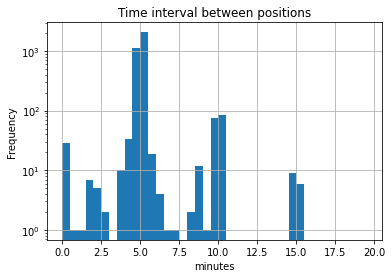

In [29]:
df["dt"] = df.groupby(df.index).apply(lambda df: df.sort_values("time")["time"].diff()/pd.Timedelta("1m")).droplevel(0)

# drop small time intervals
#df = df.loc[df.dt>3]

fig, ax = plt.subplots(1,1)
df["dt"].plot.hist(bins=np.arange(0,20,0.5))
ax.set_yscale("log")
ax.grid()
ax.set_title("Time interval between positions")
ax.set_xlabel("minutes")

_frac = df["dt"].loc[ np.abs(df.dt-5)<1 ].size / df["dt"].size
print(f"Percentage of time invervals between 4 and 6 minutes: {_frac*100:.0f}%")

Show raw speed distribution (for despiking purposes)

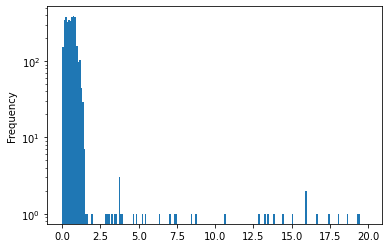

In [6]:
df_speed = df.groupby(df.index).apply(lambda df: df.sort_values("time").set_index("time")
                                      .geo.compute_velocities(acceleration=True, keep_dt=True)
                                     ).droplevel(0)
fig, ax = plt.subplots(1,1)
df_speed.velocity.plot.hist(bins=np.arange(0,20,0.1))
ax.set_yscale("log")

Acceleration:

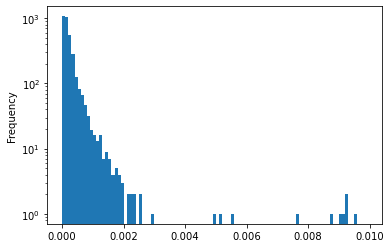

In [7]:
fig, ax = plt.subplots(1,1)
#np.abs(df_speed["acc_x"]).plot.hist(bins=np.arange(0.,.01,1e-4))
#np.abs(df_speed["acc_y"]).plot.hist(bins=np.arange(0.,.01,1e-4))
np.abs(df_speed["acc"]).plot.hist(bins=np.arange(0.,.01,1e-4))
ax.set_yscale("log")
#2/3600/6

Raw time series

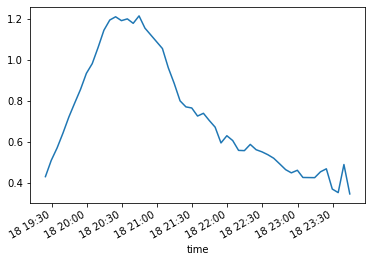

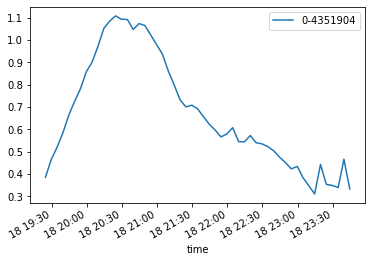

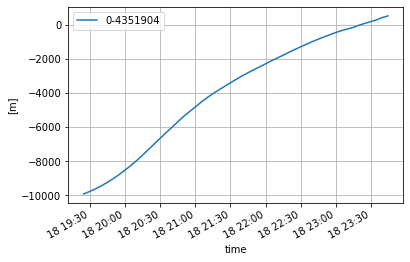

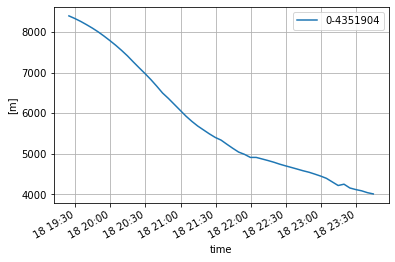

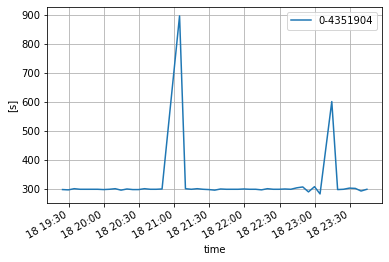

In [8]:
sl=slice(400,450)
#sl=slice(0,None)

#_df = df_speed
_df = df_speed.loc[df_speed["CommId"]=='0-4351904']


fig, ax = plt.subplots(1,1)
_df.groupby("CommId").apply(lambda df: df["velocity"].iloc[sl].plot())

fig, ax = plt.subplots(1,1)
_df.groupby("CommId").apply(lambda df: df["ux"].iloc[sl].plot(label=df.name)) #.iloc[50:100]
ax.legend()

fig, ax = plt.subplots(1,1)
_df.groupby("CommId").apply(lambda df: (df["x"].iloc[sl] ).plot(label=df.name) ) # .iloc[200:300]
ax.legend()
ax.set_ylabel("[m]")
ax.grid()

fig, ax = plt.subplots(1,1)
_df.groupby("CommId").apply(lambda df: (df["y"].iloc[sl]).plot(label=df.name) ) # .iloc[200:300]
ax.legend()
ax.set_ylabel("[m]")
ax.grid()

fig, ax = plt.subplots(1,1)
_df.groupby("CommId").apply(lambda df: (df["dt"].iloc[sl]).plot(label=df.name) ) # .iloc[200:300]
ax.legend()
ax.set_ylabel("[s]")
ax.grid()

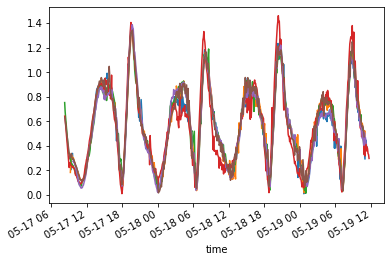

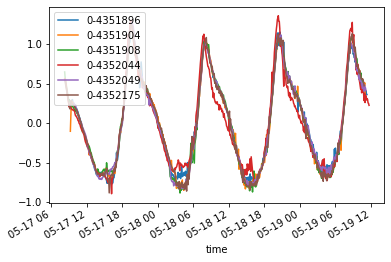

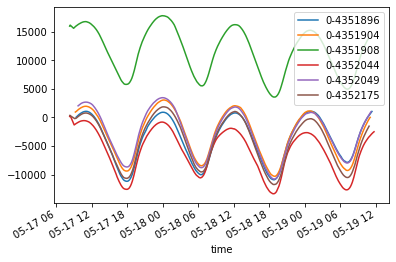

In [9]:
# drop high velocity values
#df_speed = df_speed.loc[df_speed.velocity.shift(-1)<2.]

# drop high acceleration values
_df_speed = df_speed.loc[df_speed.acc<1e-3]

fig, ax = plt.subplots(1,1)
_df_speed.groupby("CommId").apply(lambda df: df["velocity"].plot())

fig, ax = plt.subplots(1,1)
_df_speed.groupby("CommId").apply(lambda df: df["ux"].plot(label=df.name)) #.iloc[50:100]
ax.legend()
fig, ax = plt.subplots(1,1)
_df_speed.groupby("CommId").apply(lambda df: df["x"].plot(label=df.name)) # .iloc[200:300]
ax.legend()

Show an histogram of data in (dl, dt) space

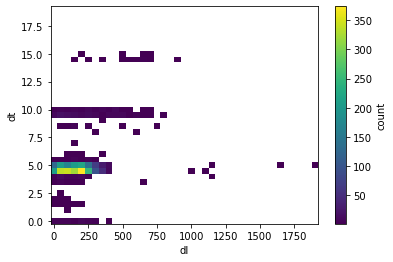

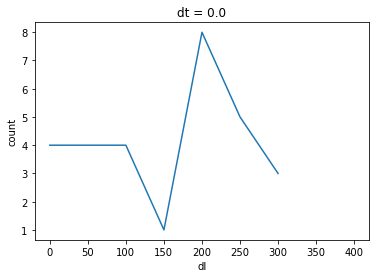

In [10]:
def dtdl_hist(df):
    # copy and project
    df = df.copy()
    df.geo.project()

    # define bins
    dt_bins = np.arange(0,20,0.5) # in minutes
    dl_bins = np.arange(0,2000,50) # in m

    # compute time and space steps
    df["dt"] = df.groupby(df.index).apply(lambda _df: _df.sort_values("time")["time"].diff()/pd.Timedelta("1m")).droplevel(0)
    df["dx"] = df.groupby(df.index).apply(lambda _df: _df.sort_values("time")["x"].diff()).droplevel(0)
    df["dy"] = df.groupby(df.index).apply(lambda _df: _df.sort_values("time")["y"].diff()).droplevel(0)
    df["dl"] = np.sqrt(df.dx**2+df.dy**2)
    
    # cut prior to grouping
    df["dt_cut"] = pd.cut(df.dt, dt_bins)
    df["dl_cut"] = pd.cut(df.dl, dl_bins)
    # count
    dfc = df.groupby(["dt_cut", "dl_cut"]).count()["dx"].reset_index()
    # massage and convert to xarray
    dfc.loc[:,["dt", "dl"]] = dfc.apply(lambda row: pd.Series(dict(dt=row["dt_cut"].left, dl=row["dl_cut"].left)), axis=1)
    da = dfc.set_index(["dt", "dl"])["dx"].to_xarray().rename("count")
    da = da.where(da>0)
    
    return da

da = dtdl_hist(df)
da.plot()

fig, ax = plt.subplots(1,1)
da.isel(dt=0).plot()

At lag 0, the mode of the spatial spacing is 200m.

Velocity associated with a 300m error over 10 minutes:

In [11]:
dl = 200 # meters
dt = 10 # minutes
print(f"speed error={dl/(dt*60):.2f} m/s for dt={dt} min and dl={dl} m")

speed error=0.33 m/s for dt=10 min and dl=200 m


### denoise based on acceleration with a threshold of 0.001 m^2/s

In [12]:
def _denoise(df):
    df.geo.project()
    # drop times that are two close
    df = df.set_index("time").geo.compute_velocities(acceleration=True)
    return df.loc[df.acc<1e-3]

df_denoised = (df.groupby("id").apply(_denoise)
               .reset_index().set_index("id")
               .drop(columns=["x", "y", "ux", "uy", "velocity", "acc_x", "acc_y", "acc"])
              )
df_denoised.head()

,time,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude
id,,,,,,,,
0-4351896,2022-05-18 15:37:21,GOOD,0-4351896,0,0,3,49.381120,-0.319612
0-4351896,2022-05-17 23:12:20,GOOD,0-4351896,0,0,3,49.368052,-0.244832
0-4351896,2022-05-17 14:22:23,GOOD,0-4351896,0,0,3,49.362044,-0.305364
0-4351896,2022-05-19 03:37:24,GOOD,0-4351896,0,0,3,49.380347,-0.279851
0-4351896,2022-05-18 15:42:19,GOOD,0-4351896,0,0,3,49.382246,-0.322595


### filter data, compute velocities

We target a 20 minute time line.
This is a consequence of the substantial noise observed on velocities at 10minutes

In [13]:
rule = "20T" # 20 m
def _resample(df):
    df = df.sort_values("time").set_index("time")
    df = df.geo.resample(rule) #, interpolate=True
    # interpolate
    df = df.geo.resample(rule, interpolate=True)
    #assert df.geo._geo_proj_ref, "no geo proj ref" # as it should
    # add velocity
    df = df.geo.compute_velocities()
    return df.reset_index("time")

dfi = df_denoised.groupby("id").apply(_resample).droplevel(1)

### extract drifter ids and test if both ids sources are identical

In [14]:
ids = list(df.index.unique())
ids_cp = [u for u in cp if  "0-435" in u]
print(ids)
set(ids) == set(ids_cp)

['0-4351896', '0-4351904', '0-4351908', '0-4352044', '0-4352049', '0-4352175']


True

In [15]:
i = ids_cp[2]
print(i)
dfi.loc[i].geo.plot_bokeh(unit=cp[i])

0-4352049


Loading BokehJS ...

### trim data and concatenate back

The output below is used to adjust the campaign yaml file

In [16]:
D = []
for i in ids:
    _df = dfi.loc[i].set_index("time")
    for d in cp[i]:
        print("----")
        _dft = _df.geo.trim(d)
        _dft.loc[:, "deployment"] = d.label
        _dft.loc[:, "id"] = i
        start = _dft.iloc[0][["longitude", "latitude"]]
        end = _dft.iloc[-1][["longitude", "latitude"]]
        print(i, d.label, f"start = {start.name}  {start.longitude:.4f}  {start.latitude:.4f}", )
        print(i, d.label, f"end = {end.name}  {end.longitude:.4f}  {end.latitude:.4f}", )
        D.append(_dft)

dfit = pd.concat(D, axis=0).reset_index().set_index("id")
dfit.head()

----
0-4351896 d0 start = 2022-05-17 09:40:00  -0.2459  49.3400
0-4351896 d0 end = 2022-05-19 11:00:00  -0.2420  49.3703
----
0-4351904 d0 start = 2022-05-17 09:20:00  -0.2424  49.3387
0-4351904 d0 end = 2022-05-19 10:40:00  -0.2626  49.3868
----
0-4351908 d0 start = 2022-05-17 08:40:00  -0.2441  49.3390
0-4351908 d0 end = 2022-05-19 10:20:00  -0.2745  49.3985
----
0-4352044 d0 start = 2022-05-17 09:00:00  -0.2571  49.3337
0-4352044 d0 end = 2022-05-19 11:40:00  -0.2744  49.3464
----
0-4352049 d0 start = 2022-05-17 09:40:00  -0.2232  49.3418
0-4352049 d0 end = 2022-05-19 11:00:00  -0.2399  49.3818
----
0-4352175 d0 start = 2022-05-17 09:20:00  -0.2424  49.3386
0-4352175 d0 end = 2022-05-19 10:40:00  -0.2642  49.3926


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,time,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,x,y,ux,uy,velocity,deployment
id,,,,,,,,,,,,
0-4351896,2022-05-17 09:40:00,0.0,0.0,3.0,49.339996,-0.245942,486.942445,-277.990901,0.245940,-0.143176,0.284581,d0
0-4351896,2022-05-17 10:00:00,0.0,0.0,3.0,49.338449,-0.242536,734.523943,-450.070782,0.206318,-0.143400,0.251258,d0
0-4351896,2022-05-17 10:20:00,0.0,0.0,3.0,49.337113,-0.239821,931.824526,-598.570348,0.164417,-0.123750,0.205784,d0
0-4351896,2022-05-17 10:40:00,0.0,0.0,3.0,49.335820,-0.238266,1044.900275,-742.352760,0.094230,-0.119819,0.152433,d0
0-4351896,2022-05-17 11:00:00,0.0,0.0,3.0,49.334592,-0.238062,1059.752887,-879.006872,0.012377,-0.113878,0.114549,d0


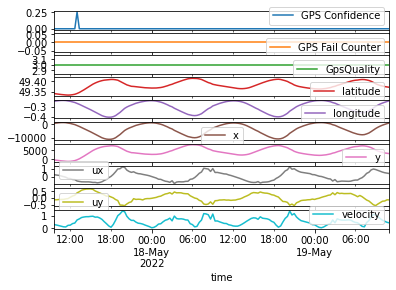

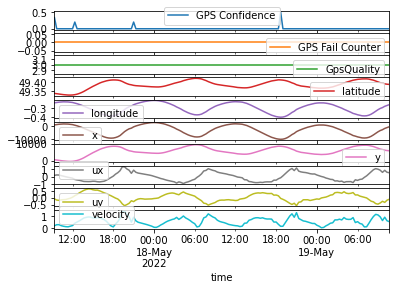

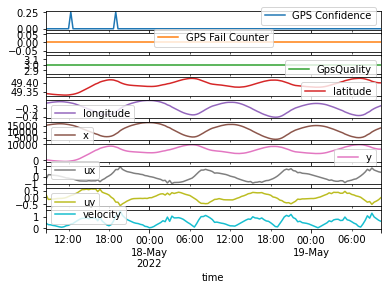

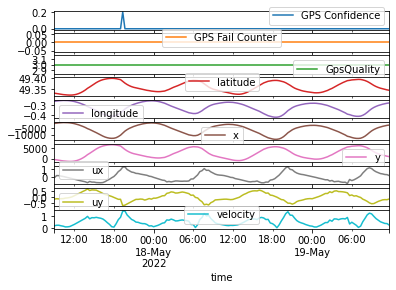

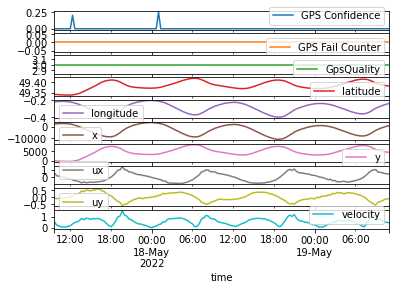

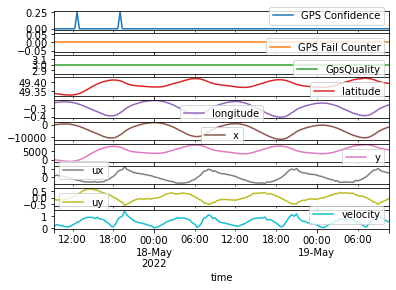

In [17]:
for i in ids:
    dfit.loc[i].set_index("time").plot(subplots=True) #x="longitude", y="latitude"

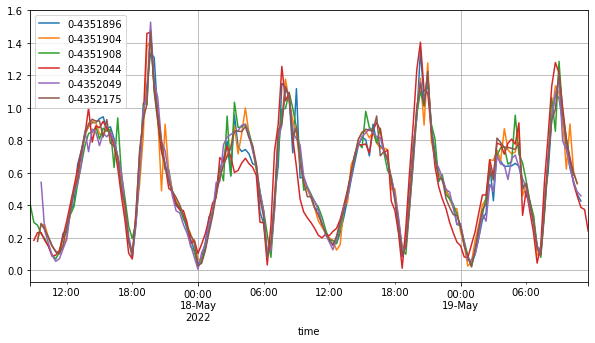

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
for i in ids:
    dfit.loc[i].set_index("time")["velocity"].plot(label=i) #x="longitude", y="latitude"
ax.legend()
ax.grid()

### overview map of the trajectories

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


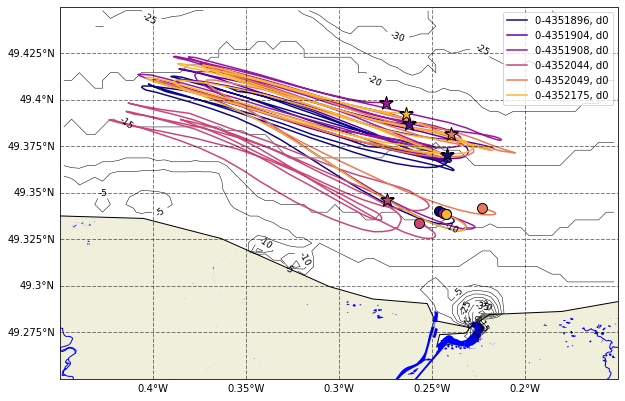

In [19]:
#bounds=[-.5, -.1, 49.25, 49.5]
if campaign=="taos0_drifters0":
    bounds=[-.4, .0, 49.25, 49.4] # taos0-drifters0
elif campaign=="taos0_drifters1":
    bounds=[-.45, -.15, 49.25, 49.45] # taos0-drifters1

_df = dfit.reset_index().set_index(["id", "deployment"])
    
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index().dropna(axis=1)
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))
    ax.scatter(_dfk.longitude.iloc[0], _dfk.latitude.iloc[0], color=c, transform=crs,
            edgecolor="k", s=100, zorder=10, marker="o",
           )
    ax.scatter(_dfk.longitude.iloc[-1], _dfk.latitude.iloc[-1], color=c, transform=crs,
            edgecolor="k", s=200, zorder=10, marker="*",
           )

ax.legend()

In [20]:
# store
dfit.to_xarray().to_netcdf(os.path.join(cp.pathp, 'drifters.nc'), mode="w")

---

# focus on jumps

In [4]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

L, Y = [], []

# taos0-drifters0
c = "taos0_drifters0"
L.append(c)
Y.append(f"drifters0/{c}.yaml")

# taos0-drifters1
c = "taos0_drifters1"
L.append(c)
Y.append(f"drifters1/{c}.yaml")

C = {l: pin.campaign(os.path.join(root_dir,y), verbose=False) for l, y in zip(L,Y)}

In [5]:
D = []
i=0
for c, cp in C.items():
    drifter_file = os.path.join(cp.pathr, "drifters.csv")
    df = read_drifters(drifter_file)
    #df.index = df.index.map(lambda _id: _id+f"_{i}")
    df.set_index(df.index.map(lambda _id: _id+f"_{i}"), inplace=True)
    D.append(df)
    i+=1
df = pd.concat(D, axis=0)
df.geo.project()
df

,time,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,x,y
id,,,,,,,,,,
0-4351896_0,2022-05-11 16:15:06,GOOD,0-4351896,0,0,3,49.333505,-0.184472,0.000000,0.000000
0-4351896_0,2022-05-11 11:10:15,GOOD,0-4351896,0,0,3,49.342475,-0.244145,-4336.364600,999.322954
0-4351896_0,2022-05-12 23:55:06,GOOD,0-4351896,0,0,3,49.337325,-0.068836,8404.002464,431.278796
0-4351896_0,2022-05-12 12:10:07,GOOD,0-4351896,0,0,3,49.342614,-0.048473,9882.850383,1021.966244
0-4351896_0,2022-05-11 20:05:07,GOOD,0-4351896,0,0,3,49.320652,-0.113940,5127.740979,-1427.066303
...,...,...,...,...,...,...,...,...,...,...
0-4352175_1,2022-05-18 22:38:51,GOOD,0-4352175,0,0,3,49.376914,-0.274701,-6552.254835,4831.716208
0-4352175_1,2022-05-17 18:03:36,GOOD,0-4352175,0,0,3,49.410635,-0.388577,-14811.554574,8598.181219
0-4352175_1,2022-05-18 09:18:37,GOOD,0-4352175,0,0,3,49.388180,-0.276439,-6676.938701,6084.840084


Percentage of time invervals between 4 and 6 minutes: 92.15%
Percentage of time invervals shorter than 1 minute: 0.98%


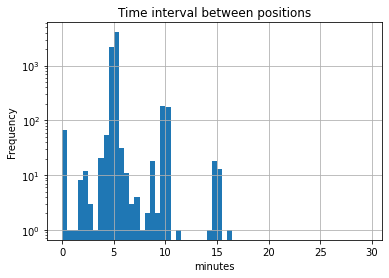

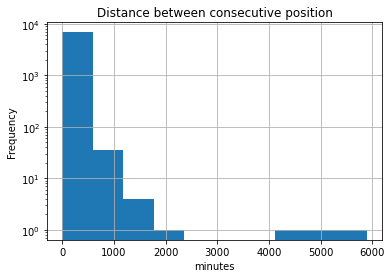

In [34]:
def _get_dl(df):
    df = df.sort_values("time")
    df_plus = df.shift(-1)
    df["dt"] = (df_plus["time"] - df["time"])/pd.Timedelta("1m")
    df["dl"] = np.sqrt((df_plus["x"] - df["x"])**2+(df_plus["y"] - df["y"])**2)
    return df[["dt", "dl"]]
    
_df = df.groupby(df.index).apply(_get_dl).droplevel(0)
_df = _df.loc[_df.dl<1e4]

fig, ax = plt.subplots(1,1)
_df["dt"].plot.hist(bins=np.arange(0,30,0.5)) #, density=True
ax.set_yscale("log")
ax.grid()
ax.set_title("Time interval between positions")
ax.set_xlabel("minutes")

fig, ax = plt.subplots(1,1)
#bins=np.arange(0,20,0.5)
_df["dl"].plot.hist() #, density=True
ax.set_yscale("log")
ax.grid()
ax.set_title("Distance between consecutive position")
ax.set_xlabel("minutes")

_frac = _df["dt"].loc[ np.abs(_df.dt-5)<1 ].size / _df["dt"].size
print(f"Percentage of time invervals between 4 and 6 minutes: {_frac*100:.2f}%")

_frac = _df["dt"].loc[ np.abs(_df.dt)<1 ].size / _df["dt"].size
print(f"Percentage of time invervals shorter than 1 minute: {_frac*100:.2f}%")

In [35]:
def _compute_diff(df):
    df = df.sort_values("time")
    df_plus = df.shift(-1)
    df_plus2 = df.shift(-2)
    df_minus = df.shift(1)
    df["dt_plus"] = (df_plus["time"] - df["time"])/pd.Timedelta("1m")
    df["dt_minus"] = (df["time"] - df_minus["time"])/pd.Timedelta("1m")
    df["dl_plus"] = np.sqrt((df_plus["x"] - df["x"])**2+(df_plus["y"] - df["y"])**2)
    df["dl_plus2"] = np.sqrt((df_plus2["x"] - df_plus["x"])**2 + (df_plus2["y"] - df_plus["y"])**2)
    df["dl_minus"] = np.sqrt((df["x"] - df_minus["x"])**2+(df["y"] - df_minus["y"])**2)
    return df[["dt_plus", "dt_minus", "dl_plus", "dl_minus", "dl_plus2"]]

dfd = df.groupby(df.index).apply(_compute_diff).droplevel(0)
dfd = dfd.loc[ (dfd.dl_plus<1e4)&(dfd.dl_minus<1e4) ] # drop a couple of anomalous values

In [36]:
dfd.loc[dfd.dt_minus<1].mean()

dt_plus       5.146324
dt_minus      0.258578
dl_plus     114.018172
dl_minus    115.075892
dl_plus2    120.184732
dtype: float64

In [37]:
dfd.loc[dfd.dt_plus<1].mean()

dt_plus       0.258586
dt_minus     10.294697
dl_plus     114.218964
dl_minus    125.571741
dl_plus2    113.443314
dtype: float64

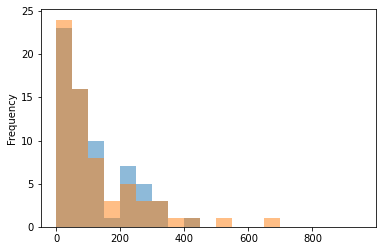

In [38]:
# 60*2=120
_df = dfd.loc[dfd.dt_plus<1]
bins = np.arange(0,1000,50)
kwargs = dict(bins=bins, alpha=0.5)
#kwargs = dict(alpha=0.5)
ax = _df["dl_plus"].plot.hist(**kwargs)
ax = _df["dl_minus"].plot.hist(**kwargs)
#ax.set_yscale("log")

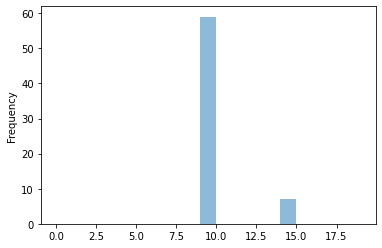

In [39]:
_df = dfd.loc[dfd.dt_plus<1]
bins = np.arange(0,20,1)
kwargs = dict(bins=bins, alpha=0.5)
ax = _df["dt_minus"].plot.hist(**kwargs)
#ax = _df["dl_minus"].plot.hist(bins=bins, alpha=0.5)
#ax.set_yscale("log")

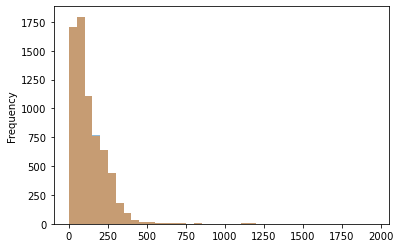

In [40]:
_df = dfd.loc[dfd.dt_plus>1]
bins = np.arange(0,2000,50)
ax = _df["dl_plus"].plot.hist(bins=bins, alpha=0.5)
ax = _df["dl_minus"].plot.hist(bins=bins, alpha=0.5)
#ax.set_yscale("log")

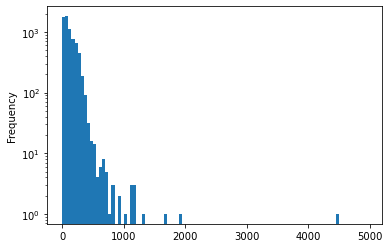

In [41]:
ax = dfd["dl_plus"].plot.hist(bins=np.arange(0,5000,50))
ax.set_yscale("log")